# M/EEG processing using MNE-Python

*IMPRS - Using Python for Cognitive Science (2022). This tutorial is based on work by [Sophie Slaats](https://www.mpi.nl/people/slaats-sophie), and on  several [MNE-python](https://mne.tools/stable/) tutorials*

Good morning! Today we will be working through this tutorial to get familiar with MNE-Python. We are going to do an analysis of MEG/EEG data provided by MNE.

At the end of this tutorial you'll know
- How to read in M/EEG data
- How to visualize the data and detect artefacts 
- How to perform basic preprocessing steps, such as rereferencing, filtering and (if time permits) identify eyeblinks in the data
- How to define Epochs based on trigger values
- How to plot ERPs and topomaps 




In [ ]:
# For people who forgot to install mne already
import sys
!{sys.executable} -m pip install mne


## 0. Importing modules

We will need os, NumPy, matplotlib, and (*of course*) MNE-Python.

<font color='green'>**Exercise 1:**</font> Import them below. We have added matplotlib for you already.  



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

### Your code here
import os as os
import numpy as np
import mne as mne

#### File format
MNE-Python uses the FIF file format from Neuromag. The MPI EEG uses BrainVision and the Donders MEG is CTF - that is not a problem, because MNE provides data reader-functions for a wide variety of other data formats (see also here: https://mne.tools/stable/overview/implementation.html#data-formats)

Let's now get an example dataset. There are many datasets available on [openneuro](https://openneuro.org/search/modality/eeg), [osf](https://osf.io/) etc. If you want, feel free to get a dataset (one participant) that you find interesting! Note that different datasets are often saved in different ways and formats (which system was used, how triggers were coded etc), so you might run in to some 'problems' later in this tutorial (but we are happy to help with those issues). Otherwise, the code below is generated using sample data from the MNE website. 

These data were acquired with the Neuromag Vectorview system. EEG data from a 60-channel electrode cap were acquired simultaneously with the MEG (!). In this experiment, checkerboard patterns were presented into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The participant was asked to press a key with the right index finger as soon as possible after the appearance of the smiley face.

Trigger codes:

    Name     ID	#Contents
    LA	    1	Response to left-ear auditory stimulus
    RA	    2	Response to right-ear auditory stimulus
    LV	    3	Response to left visual field stimulus
    RV	    4	Response to right visual field stimulus
    smiley	5	Response to the smiley face
    button	32   Response triggered by the button press
    
[Source](https://mne.tools/stable/generated/mne.datasets.sample.data_path.html#mne.datasets.sample.data_path)

## 1. Reading in the data

To access the data, we use ```read_raw_fif``` function. This creates an instance of MNE's Raw class (= an object!). The Raw object has an attribute <i>info</i>: this attribute contains information about the dataset.

Here, we will load the data into memory ```preload``` flag inside the reader function. If we don't do that, the data will be retrieved on the go instead of loading it to memory. This is useful if you're working with multiple participants' data: the memory of your computer is not unlimited.

Good to know is that you can still access the info attribute if you don't preload the data.


<font color='Purple'>**To do:**</font> Run the code cell below to download the MNE example data. Note that this may take a while. 


In [ ]:
default_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(default_path, 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(raw_fname, preload=True)

<font color='green'>**Exercise 2:**</font> Print the raw object below to see what information it gives you. Then print the info attribute. What new information do you see? What is the sampling frequency of the data, how many bad channels are there?


In [ ]:
### your code here 
print(raw)

In [ ]:
### your code here 
print(raw.info)

To access a particular element of this dictionary, you can use square brackets as you would with a normal Python dictionary.

<font color='green'>**Exercise 3:**</font> Try printing the sampling rate, bad channels, and channel names below.



In [ ]:
print('Number of channels: ', raw.info['nchan'])

print('sampling rate', raw.info['sfreq'])
print('bad channels', raw.info['bads'])
print('channel names', raw.info['ch_names'])

### Your code here


The experiment data can be accessed through raw._data. What shape do you think it should have? How many columns and rows? Try to figure it out using a NumPy function.


In [ ]:
### Your code here

rawdata_array = np.array(raw._data)
print(len(rawdata_array))

print(rawdata_array.shape)

Raw objects also have several built-in plotting methods; Here we show the power spectral density (PSD) for each sensor type with `plot_psd`

In [ ]:
raw.plot_psd(fmax=100, picks = 'eeg')


<font color='green'>**Exercise 4:**</font>  Try to plot 2 seconds of data for 30 channels below.


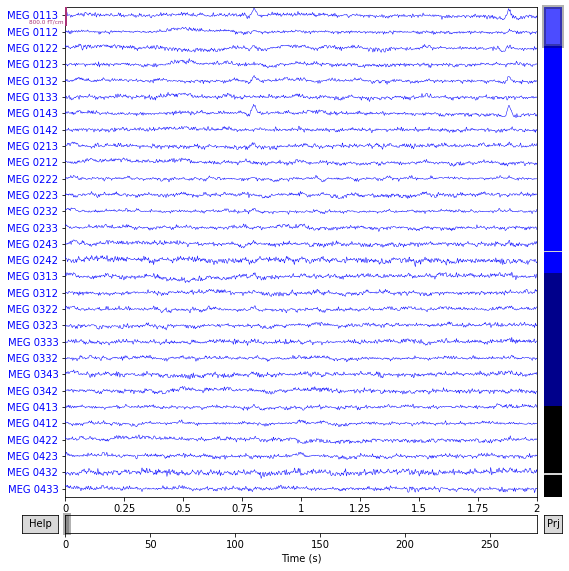

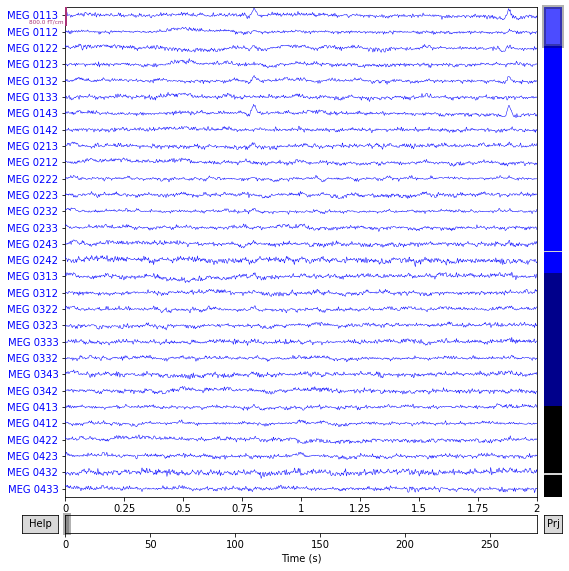

In [31]:
### Your code here
raw.plot(duration= 2, n_channels=30)

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


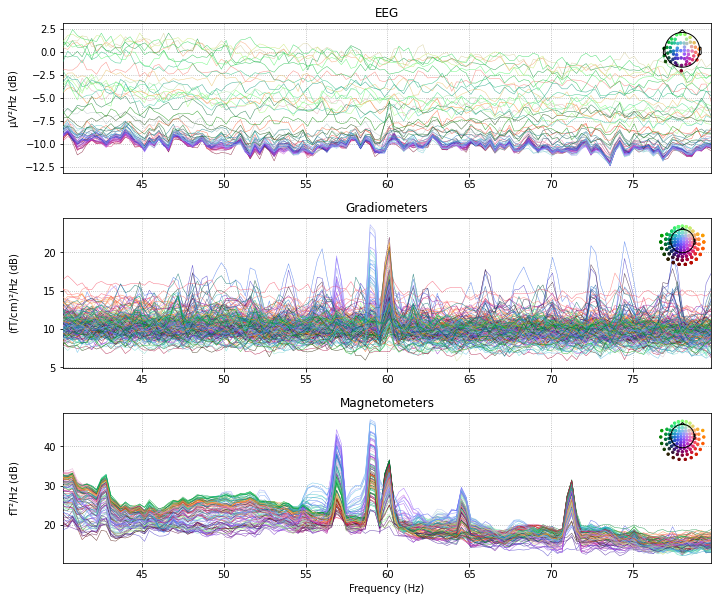

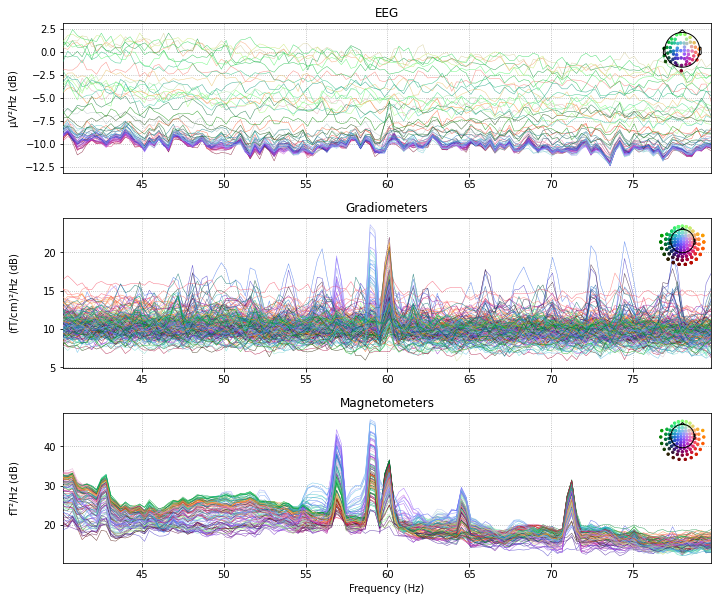

In [32]:
raw.plot_psd(fmin=40, fmax=80)

The raw object also has some other useful methods to manipulate the data. Some of them are:

- `raw.copy()` - Get a deep copy of the raw data to avoid modifying the original files
- `raw.crop([tmin, tmax])` - Crop the data based on time
- `raw.get_data([picks, start, stop,...])` - Get specific parts of the data, without metadata
- `raw.filter(l_freq, h_freq[,picks,...])` - Apply band-pass filters
- `raw.resample(sfreq[,npad, window, stim_picks, ...])` - Change the sampling rate of the data
- `raw.save(fname[,picks, tmin, tmax,...])` - Save data (possibly after preprocessing)
- `raw.set_eeg_reference()` - Specify the reference for EEG data
- `raw.to_data_frame()` - Export data as a DataFrame to use with MATLAB/R/Pandas
` 

## 2. Preprocessing

### 2.1 Filtering data

After examining your data, the first thing researchers often do is filter them based on what kind of analysis you want to do. A filter removes or attenuates parts of a signal. Usually, filters act on specific frequency ranges of a signal — for example, suppressing all frequency components above or below a certain cutoff value. For an ERP and time-frequency analysis, you would normally want to get rid of very high (e.g., above 100Hz) and very low (e.g., below 0.1 Hz) frequencies. It is important to also remove power line noise (e.g., 50Hz or 60Hz and their harmonics).

The values for your low and high pass filters depend on your effect of interest, but cannot exceed the nyquist frequency defined by your sampling rate. That is, it cannot be higher than your sampling rate divided by 2.

<font color='purple'>**To think:**</font> What is our sampling rate? And what is the maximum frequency to include in our data?



In [33]:
print(raw.info['sfreq'])
print(raw.info['sfreq']/2)


600.614990234375
300.3074951171875


To filter data with MNE, you first need to select which data are going to be filtered, and subsequently apply the respective filters only on that part of the data (i.e., we don't want to filter the stimulus channel). To accomplish this, we use the MNE function pick_types().

The function has the following signature:

`mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False, ecg=False, emg=False, ref_meg='auto', misc=False, resp=False, chpi=False, exci=False, ias=False, syst=False, seeg=False, dipole=False, gof=False, bio=False, ecog=False, fnirs=False, include=(), exclude='bads', selection=None)`

<font color='green'>**Exercise 5:**</font> In the code cell below, try to use mne.pick_types() to select the EEG channels. Assign them to a variable "picks", and print the result. Note: you don't have to specify all of them. 'False' is the default for most channel types, so they will be excluded if you don't specify them.

In [34]:
# Your code here
picks = mne.pick_types(raw.info, eeg=True)
# The following statement returns the IDs of the channels that correspond to this description
print(picks)

[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 368 369
 370 371 372 373 374]


There are three ways of applying filters to the data. You can either use a method from MNE on the data using mne.filter.filter_data(data, sfreq, picks, l_freq, h_freq) or directly apply the filter to the raw data using raw.filter(picks, l_freq, h_freq) for low/high pass filters, and raw.notch_filter(freqs, picks) to remove power line noise.

1. `mne.filter.filter_data(data, sfreq, l_freq, h_freq, picks=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1, method='fir', iir_params=None, copy=True, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)`
2. `raw.filter(l_freq, h_freq, picks=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1, method='fir', iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'), pad='reflect_limited', verbose=None)`
3. `raw.notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)`


The difference is that `mne.filter.filter_data()` will apply the filters and return a copy, while the other two methods will apply the filters in-place (directly on the data).

By default, MNE applies a FIR filter with Hanning window, but this can be modified to design specific filters. A detailed discussion of filter design is beyond the scope of this tutorial. For more in-depth information on filtering, see [here](https://mne.tools/stable/generated/mne.filter.create_filter.html#mne.filter.create_filter).


<font color='green'>**Exercise 6:**</font> In the code cell below, apply a bandpass filter from 1 to 100 Hz and a notch filter at 60Hz and its first harmonic (120Hz) on our selected channels ("picks"). Note: the frequencies in raw.notch_filter are specified by a list of integers (in our case [60, 120]).
Then use the plot_psd() method to visualise what you've done.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1983 samples (3.302 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 sec)

Effective window size : 3.410 (s)
Effective window size

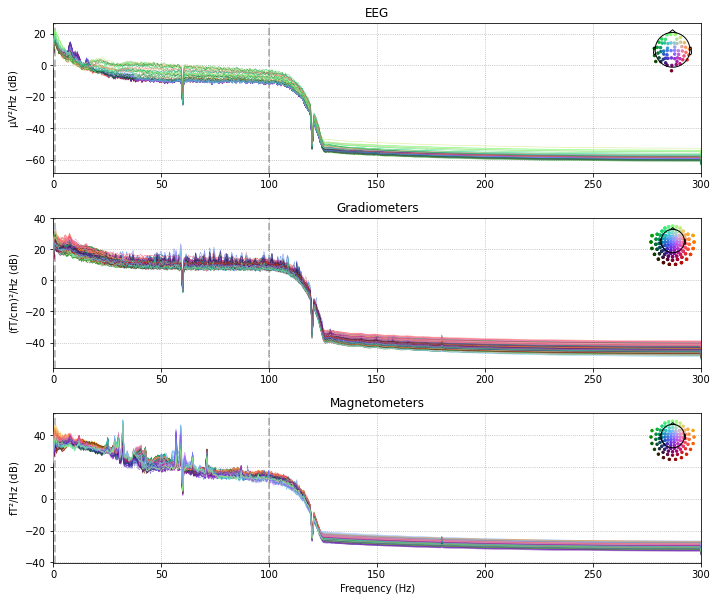

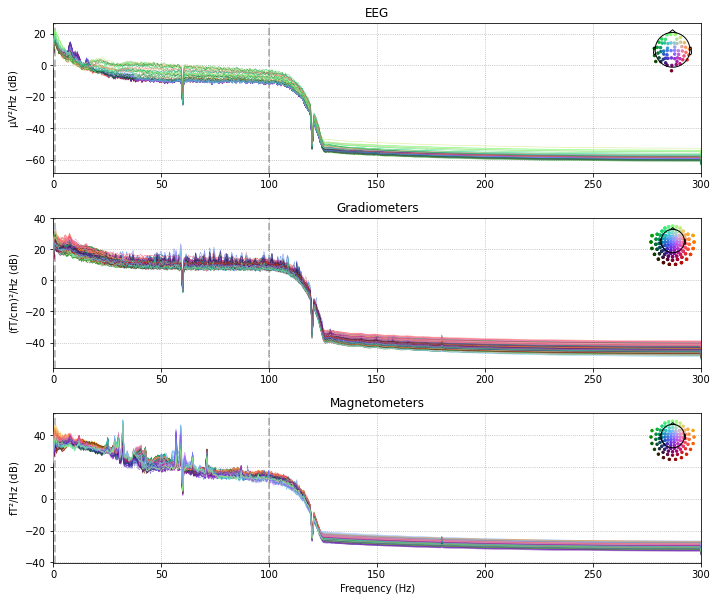

In [35]:
# Your code here
raw.filter(l_freq=1, h_freq=100)
raw.notch_filter(freqs=[60,120])
raw.plot_psd()

<font color='purple'>**To think:**</font> Why would we perform a notch filter at 60 Hz (and its harmonics)?

If you want to try different values for the filters, you have to reload the data: you have modified the data loaded in the variable raw, but not the data saved on disk. If you want, you can try it in the block below. Make sure to use a different variable name (not "raw").



In [36]:
raw.save('myeeg.fif')

Writing c:\Users\cruhr\Desktop\MPI\Python\session6a-EEGprocessing\myeeg.fif


C:\Users\cruhr\AppData\Local\Temp\ipykernel_8092\1767403928.py:1: RuntimeWarning: This filename (c:\Users\cruhr\Desktop\MPI\Python\session6a-EEGprocessing\myeeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('myeeg.fif')


Closing c:\Users\cruhr\Desktop\MPI\Python\session6a-EEGprocessing\myeeg.fif
[done]


If you wanted to save your data at this point, you could do this by using: `[your_varname].save('[YOUR_FILENAME].fif')`



### 2.2 Artifact removal

MNE-Python supports a lot of processing approaches and techniques for artifact correction. Here we'll use Independent Component Analysis (ICA). ICA separates the data into a given number of underlying components. ICA can capture systematic variability caused by physiological processes, such as blinking, breathing, and the heartbeat, in a small number of components. These components have to be identified and removed to clean the data.


In [37]:
from mne.preprocessing import ICA

#in most versions of MNE this worked fine. If you get a scikit-learn error during ICA:
import sys
!{sys.executable} -m pip install scikit-learn 

You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.



There are different methods for ICA. We will use MNE's default: FastICA. To perform ICA, you have to create an instance of the ICA class, fit it to the data, and then plot the components. To create an ICA instance, use:

`ICA(n_components=None, max_pca_components=None, n_pca_components=None, noise_cov=None, random_state=None, method='fastica', fit_params=None, max_iter=200, verbose=None)`

Where n_components can be a number of components or a percentage of the data explained, e.g. 25 for 25 components, or 0.95 for 95% of the data explained.

In [38]:
method = 'fastica'
n_components = 25
random_state = 23  # this number guarantees that anyone running the script will get the same results

ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, method: fastica>


OK, now we have an instance of the ICA class that we can apply to the data. 
First, for faster processing, we will resample the data. EEG and MEG recordings are notable for their high temporal precision, and are often recorded with sampling rates around 1000 Hz or higher. This is good when precise timing of events is important to the experimental design or analysis plan, but also consumes more memory and computational resources when processing the data.

<font color='green'>**Exercise 7:**</font> resample the data to 200Hz below using raw.resample(sfreq). Then apply the ICA to the data using ica.fit(data, picks).



In [40]:
# Your code here
# resample
raw.resample(sfreq=200)

320 events found
Event IDs: [ 1  2  3  4  5 32]
320 events found
Event IDs: [ 1  2  3  4  5 32]


<Raw | sample_audvis_raw.fif, 376 x 55543 (277.7 s), ~162.6 MB, data loaded>

In [41]:
# Your code here
# fit ICA 
ica.fit(raw,picks)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 7.3s.


Method,fastica
Fit,40 iterations on raw data (55543 samples)
ICA components,25
Explained variance,98.8 %
Available PCA components,59
Channel types,eeg
ICA components marked for exclusion,—


You can visualize the topographic maps of the components by using the `ica.plot_components()` method. To plot properties of several components at once and examine them to decide if they are artifacts, you can use `ica.plot_properties(data, [index])`. Try both below.



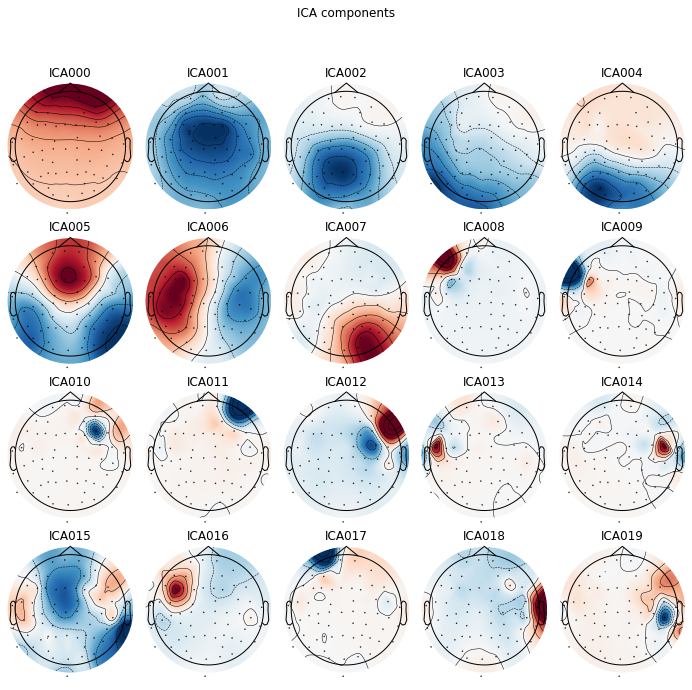

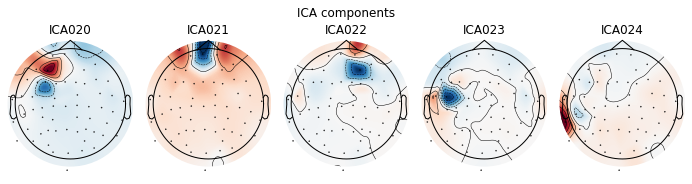

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x187.56 with 5 Axes>]

In [42]:
# Your code here
# plot components
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


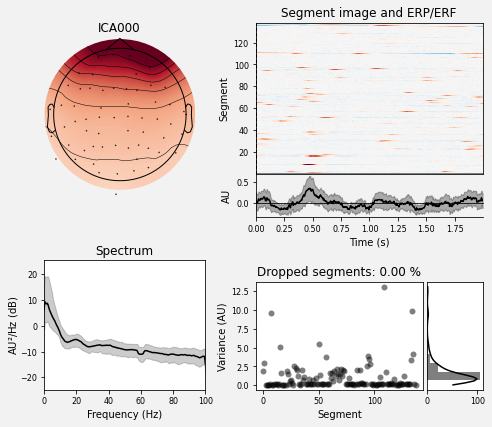

[<Figure size 504x432 with 6 Axes>]

In [43]:
# Your code here
# plot properties 
ica.plot_properties(raw, [0])

Which ones do you think are artifacts, such as blinks, eye movements, or heartbeats?

In this example we are going to remove component 0 and 6 as they represent eye movement artifacts (we will not dicsuss EEG artefacts here, for more examples see the MNE webpage). 

To remove artifacts, we use the method `ica.apply(data, exclude)`. The components are represented by their index in a list, so the second argument must be [0, 6]. In the same way, you can plot how the data would look without the excluded components before removing them by using `ica.plot_overlay(data, exclude)`. Do that first, and then remove the artifacts.

<font color='green'>**Exercise 8:**</font> 1) Plot the data without excluded components. 2) apply ICA to your data

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


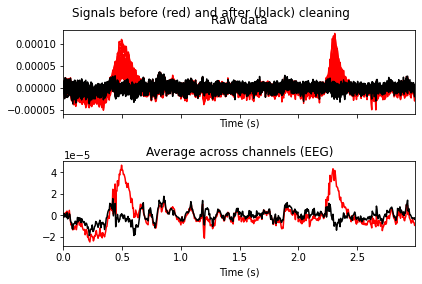

In [44]:
# Your code here
artefacts_removed = ica.plot_overlay(raw, exclude=[0,6])


In [45]:
# Your code here
raw_ica = ica.apply(raw, exclude=[0,6])


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


## 3. Experimental events



OK, our data are clean. In order to make averages over trials and further analyze the data, we need to segment the data. To do so, we need to know the onset (and possibly, the offset) of each event as identified by triggers that were sent during the experiment.

The function to get events from the data is as follows:

```mne.find_events(raw, stim_channel=None, output='onset', consecutive='increasing', min_duration=0, shortest_event=2, mask=None, uint_cast=False, mask_type='and', initial_event=False, verbose=None)```

Our stimulus channel (```stim_channel```) is <b>STI 014</b>.

<font color='green'>**Exercise 9:**</font> print `raw.ch_names` and find our stimulus channel

In [46]:
### Your code here 
print(raw.ch_names)

['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123', 'MEG 0121', 'MEG 0132', 'MEG 0133', 'MEG 0131', 'MEG 0143', 'MEG 0142', 'MEG 0141', 'MEG 0213', 'MEG 0212', 'MEG 0211', 'MEG 0222', 'MEG 0223', 'MEG 0221', 'MEG 0232', 'MEG 0233', 'MEG 0231', 'MEG 0243', 'MEG 0242', 'MEG 0241', 'MEG 0313', 'MEG 0312', 'MEG 0311', 'MEG 0322', 'MEG 0323', 'MEG 0321', 'MEG 0333', 'MEG 0332', 'MEG 0331', 'MEG 0343', 'MEG 0342', 'MEG 0341', 'MEG 0413', 'MEG 0412', 'MEG 0411', 'MEG 0422', 'MEG 0423', 'MEG 0421', 'MEG 0432', 'MEG 0433', 'MEG 0431', 'MEG 0443', 'MEG 0442', 'MEG 0441', 'MEG 0513', 'MEG 0512', 'MEG 0511', 'MEG 0523', 'MEG 0522', 'MEG 0521', 'MEG 0532', 'MEG 0533', 'MEG 0531', 'MEG 0542', 'MEG 0543', 'MEG 0541', 'MEG 0613', 'MEG 0612', 'MEG 0611', 'MEG 0622', 'MEG 0623', 'MEG 0621', 'MEG 0633', 'MEG 0632', 'MEG 0631', 'MEG 0642', 'MEG 0643', 'MEG 0641', 'MEG 0713', 'MEG 0712', 'MEG 0711', 'MEG 0723', 'MEG 0722', 'MEG 0721', 'MEG 0733', 'MEG 0732', 'MEG 0731', 'MEG 0743', 'MEG 0742', 'ME

### 3.1 Detecting events

In [47]:
events = mne.find_events(raw_ica, stim_channel='STI 014')

# Let's print the first 5 events
print(events[:5])

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[9316    0    2]
 [9438    0    3]
 [9580    0    1]
 [9729    0    4]
 [9874    0    2]]


As you can see, events have a time stamp (in samples), a code for consecutive events, and an event ID (1, 2, 3 or 4 for the stimuli; 5 for the smiley and 32 for a button press).

### 3.2 Epoching

To find our epochs, we need to tell the system which codes should be taken into account, and what they mean. For this, we can create a dictionary, containing the relevant events: 

In [48]:
# create a dictionary for the labels
event_ids = {'A/L': 1, 'A/R': 2, 'V/L': 3, 'V/R':4, 'S': 5, 'B': 32}

# A/L: left-ear auditory stimulus
# A/R: right-ear auditory stimulus
# V/L: left visual field stimulus
# V/R: right visual field stimulus
# S: smiley face
# B: button press

Event dictionaries like this one are used when extracting epochs from continuous data; the / character in the dictionary keys allows pooling across conditions by requesting partial condition descriptors (i.e., requesting 'auditory' will select all epochs with Event IDs 1 and 2; requesting 'left' will select all epochs with Event IDs 1 and 3). An example of this is shown in the next section. There is also a convenient plot_events function for visualizing the distribution of events across the duration of the recording (to make sure event detection worked as expected). Here we’ll also make use of the Info attribute to get the sampling frequency of the recording (so our x-axis will be in seconds instead of in samples).

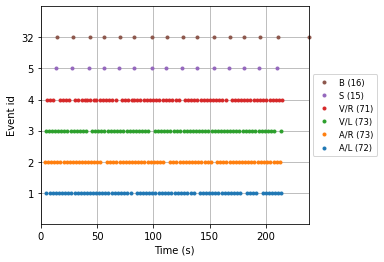

In [49]:
fig = mne.viz.plot_events(events, event_id=event_ids, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

<font color='purple'>**To think:**</font> Does the number of button presses make sense? 


Next, to segment the data, we create an instance of the Epochs class. This means that, after epoching, the data is no longer in a Raw-object; it is now in an Epochs object, with its own methods and attributes.

```mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.5, baseline=(None, 0), picks=None, preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, reject_tmax=None, detrend=None, on_missing='error', reject_by_annotation=True, metadata=None, verbose=None)```

The parameters for segmenting are the following:

* ```tmin``` - Time before trigger
* ```tmax``` - Time after trigger
* ```preload``` - Used to load the data in memory
* ```baseline``` - Baseline corrects each epoch. Normally indicated by using a tuple (None, 0), where None is automatically replaced by tmin

In [50]:
epochs = mne.Epochs(raw_ica, events, event_id=event_ids, tmin=-0.2, tmax=0.5, 
                    picks=picks, preload=True, baseline=(None, 0.0))

Not setting metadata
320 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Using data from preloaded Raw for 320 events and 141 original time points ...
0 bad epochs dropped


Let's have a look at the epoched data, for channel 60: 

Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


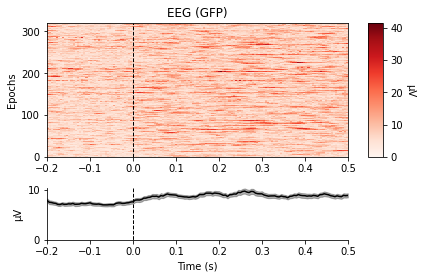

[<Figure size 432x288 with 3 Axes>]

In [51]:
epochs.plot_image()

Hmm.. not very interesting yet. Note that we've just plotted the data across *all trials* and *all channels*. We can now use our dictionary to find, for example, all trials in which a visual stimulus was presented: 

In [52]:
visual_epochs = epochs['V']

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


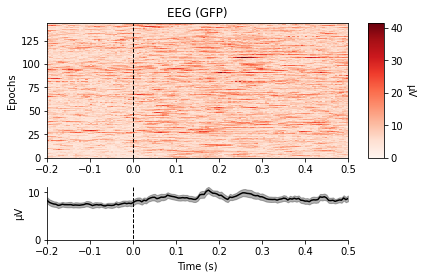

[<Figure size 432x288 with 3 Axes>]

In [53]:
visual_epochs.plot_image()

Alright! Now let's have a look at some occipital channels. To figure out the location of the channels, we can plot them: 

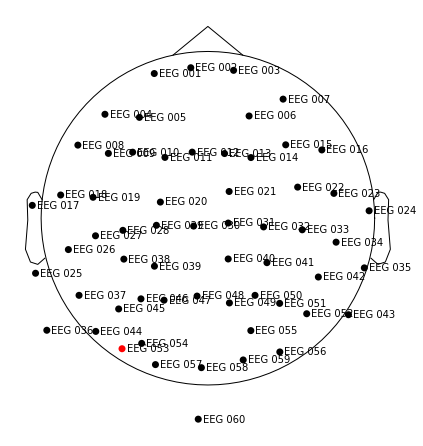

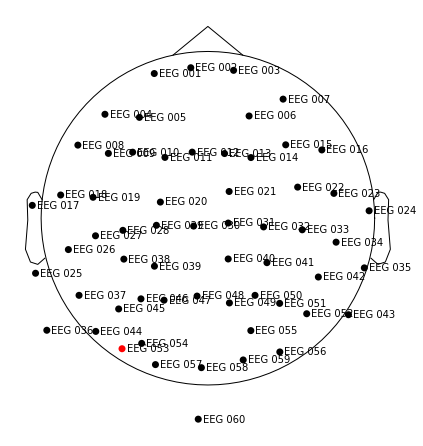

In [54]:
raw.plot_sensors(ch_type='eeg', show_names=True)

And indicate in our plot which channels we want to take into account:

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


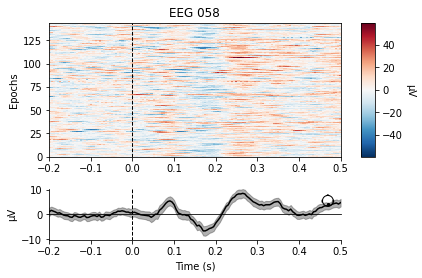

[<Figure size 432x288 with 4 Axes>]

In [55]:
visual_epochs.plot_image(picks=['EEG 058'])

In [56]:
epochs.save('sample-epo.fif')
saved_epochs = mne.read_epochs('sample-epo.fif')

FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

After epoching is a good moment to save your data. You can do this in the following way:

`epochs.save('sample-epo.fif')` 

And then read them again:

`saved_epochs = mne.read_epochs('sample-epo.fif')`

## 4. Evoked responses

To average the data by condition you can use the `epochs[condition].average(picks)` method. This will create an Evoked object that can be ploted to visualize the ERP/Fs.


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


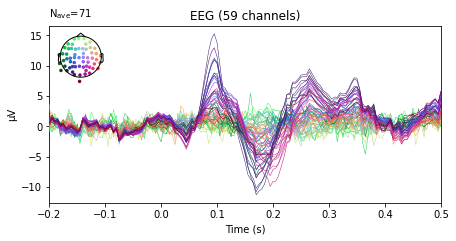

In [58]:
evoked_VR = epochs['V/R'].average()
VR_plot = evoked_VR.plot(spatial_colors=True, time_unit='s')

We see that most effects occur between time point 0 and time point 0.3. Let's make a topographic plot between these time points.

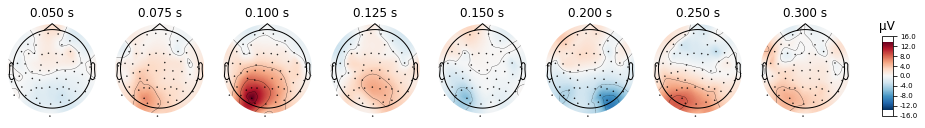

In [59]:
VR_topoplot = evoked_VR.plot_topomap(times=[0.05, 0.075, 0.1, 0.125, 0.150,0.2,0.25,0.3], time_unit='s')

Recall that a visual stimulus was presented to the right visual field. As expected, we see activity in the (left) occipital area.

<font color='yellow'>**Homework assignment**</font> 

1. Plot the averaged evoked responses for auditory stimuli, across temporal channels.  
2. Try to run a for-loop with all the conditions to visualize the evoked response separately (you can just plot all channels or make a selection, depending on your motivation).
3. Plot the averaged evoked response to the smiley faces (catch trials). Does this plot look more noisy? Is this expected? 
4. Plot the averaged evoked response to 15 V/R trials and visually compare the influence of the number of trials


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


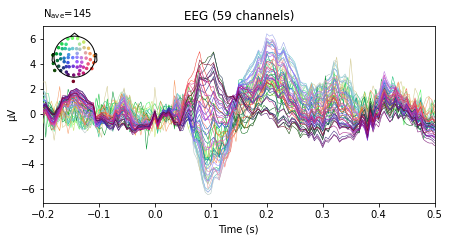

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


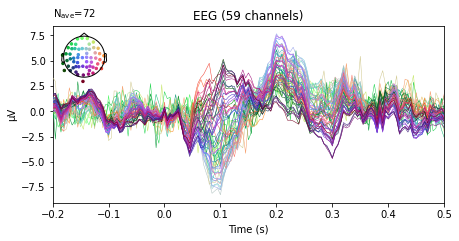

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


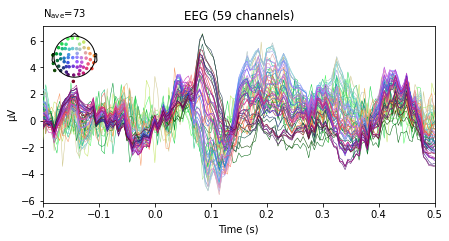

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


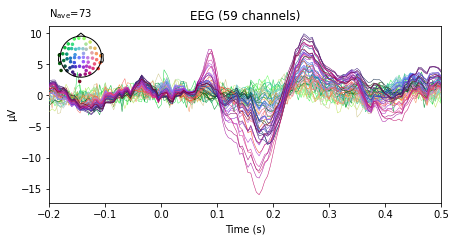

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


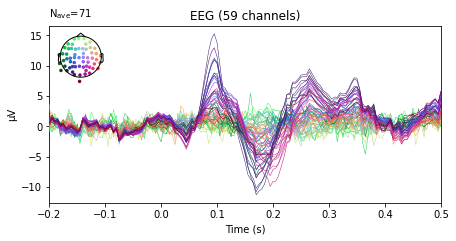

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


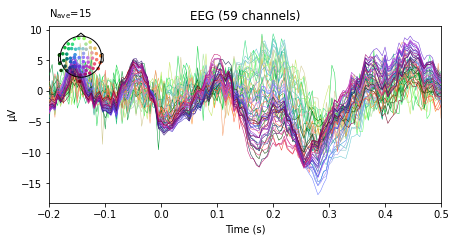

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


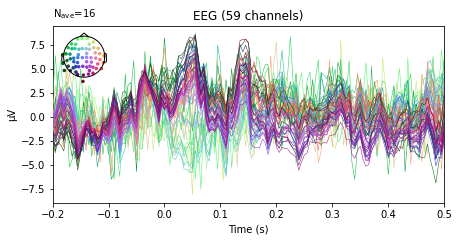

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


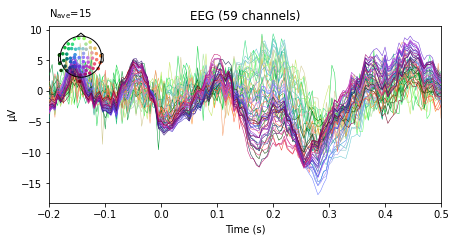

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


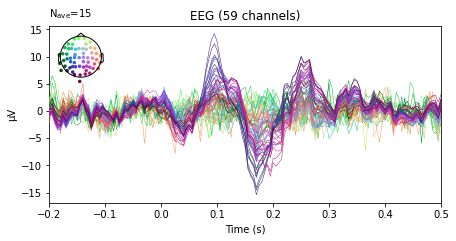

In [68]:
evoked_aud = epochs['A/R','A/L'].average()
aud_plot = evoked_aud.plot(spatial_colors=True, time_unit='s')


for i in event_ids:
    evoked = epochs[i].average()
    plot = evoked.plot(spatial_colors=True, time_unit='s')

evoked_smilie = epochs['S'].average()
smilie_plot = evoked_smilie.plot(spatial_colors=True, time_unit='s')

evoked_VR_15 = epochs['V/R'][:15]
evoked_VR_15 = evoked_VR_15.average()
VR_15_plot = evoked_VR_15.plot(spatial_colors=True, time_unit='s')


<font color='pink'>**Bonus:**</font> Instead of focusing on the EEG, have a look at the MEG data! 
- What does this tell us about line noise? 
- Can you detect eye movement components after running ICA? And what about heartbeat effects?

